### Imports

In [91]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
from pandas import to_datetime


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [92]:
buy_threshold = 1.04
sell_threshold = 1.08
starting_balance = 1000000
price_cap_lower = 0
ttm_cap_lower = 0

run_optimizing = False
google_colab = False
preparing_file = False
write_file = False

### Data loading

In [93]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "15eesIDv1QR3465iekfFG52v-HIYheguO"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('11.05 1 mnd test sett full model run_with_TTM0_Q1and2_2018_filtered_missing.csv')  
    df = pd.read_csv('11.05 1 mnd test sett full model run_with_TTM0_Q1and2_2018_filtered_missing.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/predictions/11.05 1 mnd test sett full model run_with_TTM0_Q1and2_2018_filtered_missing.csv')

### Data processing

In [94]:
df["TTM"] = (df["TTM"]*365).astype(int)

In [95]:
print(len(df))

395030


### Functions

In [96]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] / df['Price']) >= buy_threshold
    sell_signal = (df['Price'] / df['Prediction']) >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower):
    # Filter out options that expire before the last quote date
    # Timestamps are converted to dates
    df['Expiry_date'] = pd.to_datetime(df['Expiry_date']).dt.date
    df['Quote_date'] = pd.to_datetime(df['Quote_date']).dt.date
    df = df[df['Expiry_date'] <= df['Quote_date'].max()]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1

    df['Position_this_opt'] = 0
    df['Balance'] = -1000000  # Makes it easy to spot if balance has not been updated correctly

    df = df.sort_values('Quote_date')
    df['Option_ID'] = df['Option_ID'].astype(str)

    position_dict = {id:0 for id in df['Option_ID'].unique()}
    first_date = df['Quote_date'].min()
    balance_dict = {first_date: starting_balance}

    def operation(row):

        # If the row is first in a new date, create a new balance_dict key
        if row['Quote_date'] not in balance_dict.keys():
            balance_dict[row['Quote_date']] = balance_dict[max(balance_dict.keys())]

        balance = balance_dict[row['Quote_date']]

        

        position = position_dict[row['Option_ID']]

        if row['Signal'] == 1 and row["Quote_date"] != row["Expiry_date"] and balance >= row['Price']:
            balance -= row['Price']
            position += 1

        elif row['Signal'] == -1 and row["Quote_date"] != row["Expiry_date"] and balance > 0:
            balance += row['Price']
            position -= 1

        elif row["Quote_date"] == row["Expiry_date"] and position != 0:
            intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
            adjustment = intrinsic_value if position >= 1 else -intrinsic_value
            balance += adjustment * abs(position)
            position = 0

        row['Position_this_opt'] = position

        position_dict[row['Option_ID']] = position
        # Update balance dict
        balance_dict[row['Quote_date']] = balance

        row['Balance'] = balance



        return row

    df = df.apply(operation, axis=1)
    df.loc[(df['Position_this_opt'] == 0), 'Balance'] = df['Quote_date'].map(balance_dict)

    return df



def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Run code

In [97]:
def sharpe_ratio(df, rf=0.02):
    df = df.copy()

    # Calculate daily returns
    df['Daily_Returns'] = df['Total_value'].pct_change()

    starting_balance = df['Balance'].iloc[0]
    ending_balance = df['Balance'].iloc[-1]

    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days

    avg_daily_return = (ending_balance / starting_balance)**(1/num_days) - 1

    avg_daily_return_excess = avg_daily_return - rf / 252

    df["Excess_Returns"] = df["Daily_Returns"] - rf / 252

    std_daily_excess_return = df["Excess_Returns"].std()

    sharpe_ratio = np.sqrt(252) * (avg_daily_return_excess / std_daily_excess_return)

    return sharpe_ratio

In [98]:
def print_results(df, starting_balance):
    print("Starting balance", starting_balance)
    print("Ending balance", df['Balance'].iloc[-1])
    print("Number of trades", df['Signal'].abs().sum())
    profit = df['Balance'].iloc[-1] - starting_balance
    print("Profit", profit)
    print("Profit per trade", profit / df['Signal'].abs().sum())
    # Convert the 'Quote_date' column to datetime
    df['Quote_date'] = to_datetime(df['Quote_date'])
    print("Profit per day", profit / (df['Quote_date'].max() - df['Quote_date'].min()).days)
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days
    print("Number of days", num_days)
    print("Sharpe ratio: ", sharpe_ratio(df))


In [99]:
if run_optimizing == False:
    df = df.copy()
    buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
    df = trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower)
    df = calculate_options_value(df)
    print_results(df, starting_balance)

Starting balance 1000000
Ending balance 1643163.0299993965
Number of trades 153162
Profit 643163.0299993965
Profit per trade 4.199233687203069
Profit per day 3613.275449434812
Number of days 178
Sharpe ratio:  5.641211200525331


### Analysis

In [100]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Balance')
    plt.plot(df['Options_value'], label='Options value')
    plt.title('Portfolio value over time')
    # Make plot smaller
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

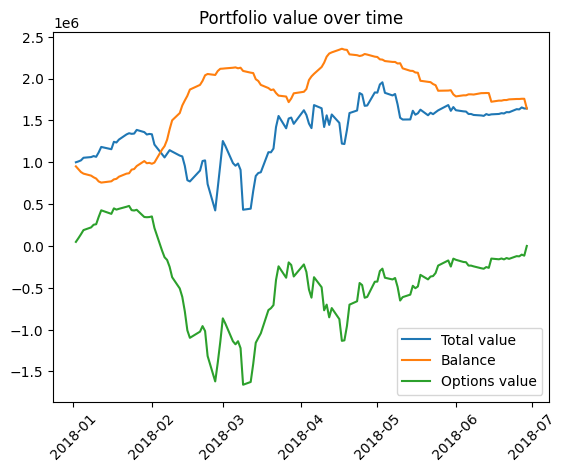

In [101]:
if run_optimizing == False:
    plot(df)

### Finding best thresholds

In [102]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': 'Latest pricing model - 1H18 - Dict',
    'metric': {
        'goal': 'maximize', 
        'name': 'sharpe_ratio'
        },
    'parameters': {
        'buy_threshold': {
            'values': [1.1, 1.06, 1.04, 1.02]},
        'sell_threshold': {
            'values': [1.1, 1.06, 1.04, 1.02]},
        'starting_balance': {
            'values': [1000000]},
        'price_cap_lower': {
            'values': [5, 1, 0]},
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


In [103]:
if run_optimizing:
    def find_best_thresholds(df = df):
        run = wandb.init(project = "options-trading")
        df = df.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, run.config.starting_balance, price_cap_lower = run.config.price_cap_lower)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio(df), "starting_balance": run.config.starting_balance, "ending_balance": df['Balance'].iloc[-1], "number_of_trades": df['Signal'].abs().sum()})
        # Wandb callback
        print_results(df, run.config.starting_balance)
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)